# Amazon_alexa_review

### Alexa is a virtual assistant that works in a similar way to popular apps like Siri or Google Now. In other words, Amazon Alexa is an assistant that responds to voice commands and performs user tasks.

<img src = "AAs.jpg" />

### 3000 reviews. The goal is to create a model that determines negative or positive feedback.

## Step #0: Import libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#to prepare dataset
import string
import nltk
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from pipelinehelper import PipelineHelper
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
#to train model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


#to check model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, recall_score, precision_score, f1_score

In [13]:
def message_cleaning(message):
    test_punc_removed = [char for char in message if char not in string.punctuation]
    
    test_punc_removed_join = ''.join(test_punc_removed)
    test_punc_removed_join_clean = [word for word in test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    return test_punc_removed_join_clean



In [14]:
#define function to create count vectorizer 
def create_count_vectorizer_and_transform(df):
    cv = CountVectorizer(analyzer = message_cleaning)
    alexa_count_vectorizer = cv.fit_transform(df['verified_reviews'])
    return alexa_count_vectorizer
    
#define function to splitting dataset using Count Vectorizer with message clening
def splitting_dataset_using_count_vectorizer(df, vectorizer):

    label = df['feedback'].values
    y = label
    X = vectorizer
    
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = 0.25,
        random_state = 0
    )
    return X_train, X_test, y_train, y_test

In [15]:
# define functions to use WordNetLemmatizer to reduce number of columns
def lemmatizeSentence(sentence):
    lemmatizer = WordNetLemmatizer()
    token_words = word_tokenize(sentence)
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(lemmatizer.lemmatize(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)    

def lemmatize (df):
    new_df = df
    new_df = new_df.drop('verified_reviews', axis=1)
    text_list = []
    for j in range(0, len(df)):
        lemmatized = lemmatizeSentence(df.iloc[j]['verified_reviews'])
        text_list.append(lemmatized)
        df.replace(df.iloc[j]['verified_reviews'],lemmatized)
    new_df.loc[:, "verified_reviews"] = text_list
    return new_df

In [16]:
#define function to create count vectorizer with Tfidf Transformer
def create_count_vectorizer_and_tfidf(df):
    cv = CountVectorizer(analyzer = message_cleaning)
    alexa_vectorizer = cv.fit_transform(df['verified_reviews'])
    alexa_tfidf = TfidfTransformer().fit_transform(alexa_vectorizer)
    return alexa_tfidf
    
#define function to splitting dataset using Count Vectorizer and TfidfTransformer with message clening
def splitting_dataset_using_count_vectorizer_and_tfidf(df, vectorizer):
    
    label = df['feedback'].values
    y = label
    X = vectorizer
    
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = 0.25,
        random_state = 0
    )
    return X_train, X_test, y_train, y_test

In [17]:
def wordcloud_plot(text, title):
    cleaned_df = message_cleaning(text)
    wc = WordCloud(
        background_color = "white", 
        max_words = 2000, 
        max_font_size = 40,
        scale = 3, colormap='tab20c',
        stopwords = STOPWORDS
    ).generate(" ".join(cleaned_df))
    plt.figure(figsize=(15,6))
    plt.imshow(wc, interpolation = "bilinear")
    plt.axis('off')
    plt.title(title)
    plt.show()

In [18]:
#define function to show the results for classifier (accuracy score and roc_auc scores)
def score_show(name, classifier, X_train, X_test, y_train, y_test):
   
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6)) 
    
    classifier.fit(X_train, y_train)
    
    print('Train: ')
    y_pred_train = classifier.predict(X_train)
  
    print('accuracy %s' % accuracy_score(y_train, y_pred_train))
    axes[0].set_title('Train Confusion Matrix')
    cm = confusion_matrix(y_train, y_pred_train)
    sns.heatmap(cm, annot = True, fmt = 'd', ax = axes[0])
    
   
    print(classification_report(y_train, y_pred_train))

    print('----------------------------------------------')

    print('Test: ')
    y_pred_test = classifier.predict(X_test)
  
    print('accuracy %s' % accuracy_score(y_test, y_pred_test))
    axes[1].set_title('Test Confusion Matrix')
    cm_t = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm_t, annot = True, fmt = 'd', ax = axes[1])
    
    
    print(classification_report(y_test, y_pred_test))

    results__accuracy.loc[len(results__accuracy.index)] = [name, accuracy_score(y_test,y_pred_test), accuracy_score(y_train, y_pred_train)]
    results_rocauc.loc[len(results_rocauc.index)] = [name, roc_auc_score(y_test, y_pred_test), roc_auc_score(y_train, y_pred_train)]
    results_precision.loc[len(results_precision.index)] = [name, precision_score(y_test,y_pred_test), precision_score(y_train, y_pred_train)]
    results_recall.loc[len(results_recall.index)] = [name, recall_score(y_test,y_pred_test), recall_score(y_train, y_pred_train)]
    results_f1.loc[len(results_f1.index)] = [name, f1_score(y_test,y_pred_test), f1_score(y_train, y_pred_train)]

In [19]:
# create variable, which store the results scores in test and train
results__accuracy = pd.DataFrame(columns=['modelName', 'accuracy_test', 'accuracy_train'])
results_rocauc = pd.DataFrame(columns=['modelName', 'rocauc_test', 'rocauc_train'])
results_precision = pd.DataFrame(columns=['modelName', 'precision_test', 'precision_train'])
results_recall = pd.DataFrame(columns=['modelName', 'recall_test', 'recall_train'])
results_f1 = pd.DataFrame(columns=['modelName', 'f1_test', 'f1_train'])

In [20]:
# define function to show briefly the results
def show_results():
    print('Accuracy')
    new_results__accuracy = results__accuracy.sort_values('accuracy_test', ascending = False)
    print(new_results__accuracy)
    print('----------------------------------------------\n')
    print('RocAuc')
    new_results_rocauc = results_rocauc.sort_values('rocauc_test', ascending = False)
    print(new_results_rocauc)
    print('----------------------------------------------\n')
    print('Precision')
    new_results_precision = results_precision.sort_values('precision_test', ascending = False)
    print( new_results_precision)
    print('----------------------------------------------\n')
    print('Recall')
    new_results_recall = results_recall.sort_values('recall_test', ascending = False)
    print(new_results_recall)
    print('----------------------------------------------\n')
    print('f1')
    new_results_f1 = results_f1.sort_values('f1_test', ascending = False)
    print(new_results_f1)

## Step#1: Import data

In [21]:
df_alexa = pd.read_csv('../amazon_alexa.tsv', sep = '\t')

In [22]:
df_alexa

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


In [23]:
df_alexa.keys()

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [24]:
df_alexa.head(10)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


In [25]:
df_alexa.tail(10)

,rating,date,variation,verified_reviews,feedback
3140,4,30-Jul-18,White Dot,Barry,1
3141,3,30-Jul-18,Black Dot,,1
3142,4,30-Jul-18,White Dot,My three year old loves it. Good for doing ba...,1
3143,5,30-Jul-18,Black Dot,Awesome device wish I bought one ages ago.,1
3144,5,30-Jul-18,Black Dot,love it,1
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1
3149,4,29-Jul-18,Black Dot,Good,1


In [26]:
categorical = [var for var in df_alexa.columns if df_alexa[var].dtype =='O']

print('There are {} categorical variables'.format(len(categorical)))

There are 3 categorical variables


Text(0, 0.5, 'Categorical variables')

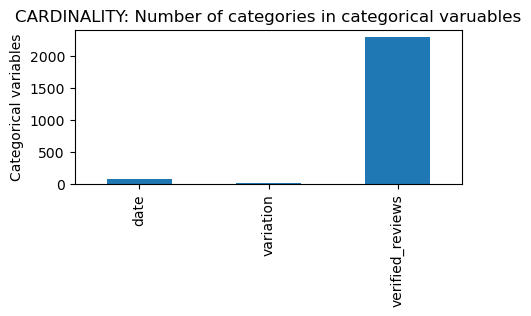

In [27]:
df_alexa[categorical].nunique().plot.bar(figsize = (5,2))

plt.title('CARDINALITY: Number of categories in categorical varuables')
plt.ylabel('Categorical variables')

In [28]:
# Cardinality -number of different categories

In [29]:
df_alexa[categorical].nunique() 

date                  77
variation             16
verified_reviews    2301
dtype: int64

In [30]:
for var in df_alexa.columns:
    print(var, df_alexa[var].unique()[0:20], '\n')

rating [5 4 3 2 1] 

date ['31-Jul-18' '30-Jul-18' '29-Jul-18' '28-Jul-18' '27-Jul-18' '26-Jul-18'
 '25-Jul-18' '24-Jul-18' '23-Jul-18' '22-Jul-18' '21-Jul-18' '20-Jul-18'
 '19-Jul-18' '18-Jul-18' '17-Jul-18' '16-Jul-18' '15-Jul-18' '14-Jul-18'
 '13-Jul-18' '12-Jul-18'] 

variation ['Charcoal Fabric ' 'Walnut Finish ' 'Heather Gray Fabric '
 'Sandstone Fabric ' 'Oak Finish ' 'Black' 'White' 'Black  Spot'
 'White  Spot' 'Black  Show' 'White  Show' 'Black  Plus' 'White  Plus'
 'Configuration: Fire TV Stick' 'Black  Dot' 'White  Dot'] 

verified_reviews ['Love my Echo!' 'Loved it!'
 'Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home.'
 'I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.'
 'Music'
 'I received the echo as a gif

In [31]:
df_alexa['date'].describe()

count          3150
unique           77
top       30-Jul-18
freq           1603
Name: date, dtype: object

<AxesSubplot: xlabel='count', ylabel='date'>

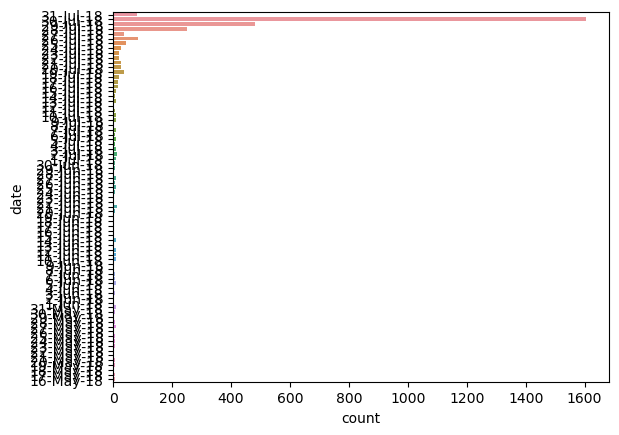

In [32]:
sns.countplot(y = 'date', data = df_alexa)

In [33]:
df_alexa['variation'].describe()

count           3150
unique            16
top       Black  Dot
freq             516
Name: variation, dtype: object

<AxesSubplot: xlabel='count', ylabel='variation'>

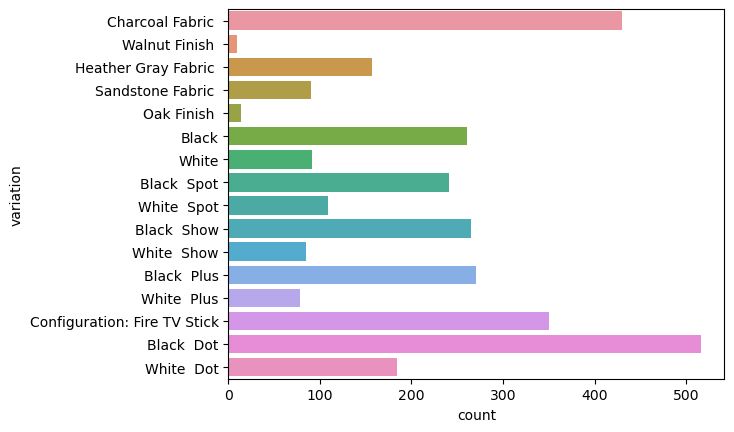

In [34]:
sns.countplot(y = 'variation', data = df_alexa)

<img src = "3.jpg" />

In [35]:
df_alexa['verified_reviews'].describe()

count     3150
unique    2301
top           
freq        79
Name: verified_reviews, dtype: object

In [36]:
df_alexa

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


## Step#2: Visualizing the data

In [37]:
positive = df_alexa[df_alexa['feedback'] == 1]

In [38]:
negative = df_alexa[df_alexa['feedback'] == 0]

In [39]:
negative 

,rating,date,variation,verified_reviews,feedback
46,2,30-Jul-18,Charcoal Fabric,"It's like Siri, in fact, Siri answers more acc...",0
111,2,30-Jul-18,Charcoal Fabric,Sound is terrible if u want good music too get...,0
141,1,30-Jul-18,Charcoal Fabric,Not much features.,0
162,1,30-Jul-18,Sandstone Fabric,"Stopped working after 2 weeks ,didn't follow c...",0
176,2,30-Jul-18,Heather Gray Fabric,Sad joke. Worthless.,0
...,...,...,...,...,...
3047,1,30-Jul-18,Black Dot,Echo Dot responds to us when we aren't even ta...,0
3048,1,30-Jul-18,White Dot,NOT CONNECTED TO MY PHONE PLAYLIST :(,0
3067,2,30-Jul-18,Black Dot,The only negative we have on this product is t...,0
3091,1,30-Jul-18,Black Dot,I didn’t order it,0


In [40]:
positive

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


<AxesSubplot: xlabel='rating', ylabel='count'>

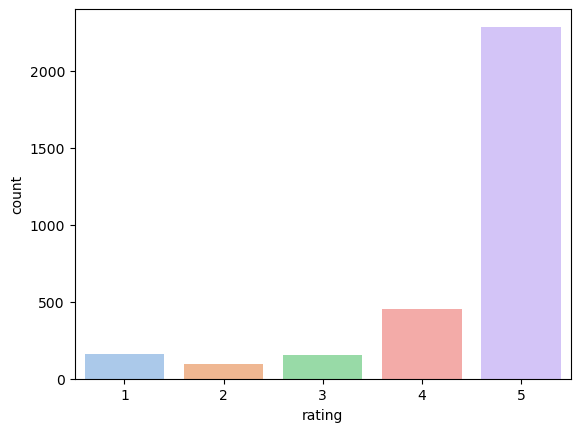

In [41]:
sns.countplot(x = 'rating', data = df_alexa, palette = 'pastel')

<AxesSubplot: >

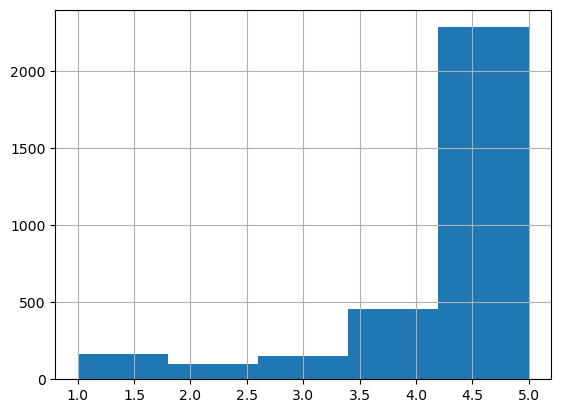

In [42]:
df_alexa['rating'].hist(bins = 5)

<AxesSubplot: xlabel='rating', ylabel='variation'>

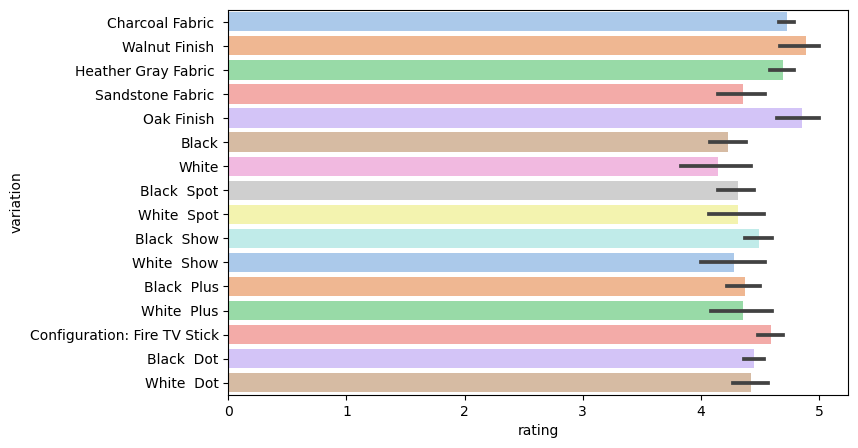

In [43]:
plt.figure(figsize = (8, 5))
sns.barplot(y = 'variation', x = 'rating', data = df_alexa, palette = 'pastel')

In [44]:
# what types of variation were made views

<function matplotlib.pyplot.show(close=None, block=None)>

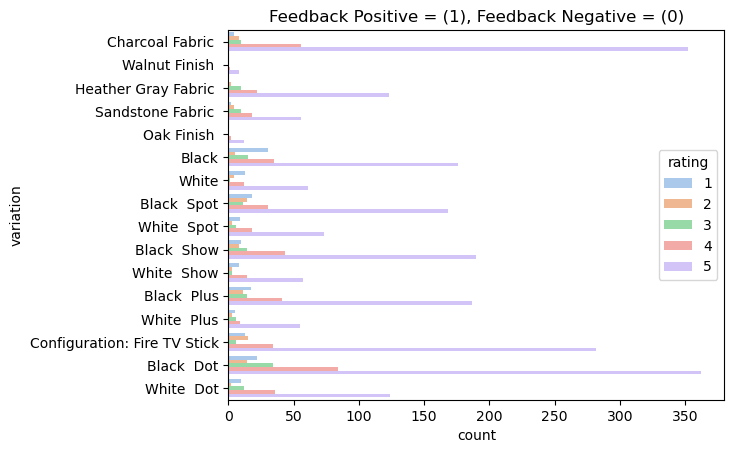

In [45]:
fig = sns.countplot(y = 'variation', hue = 'rating', data = df_alexa, palette = 'pastel')
fig = fig.set_title('Feedback Positive = (1), Feedback Negative = (0)')
plt.show

In [46]:
# Feedback Positive = (1), Feedback Negative = (0)

C:\Users\82103\AppData\Local\Temp\ipykernel_11596\1841877132.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df_alexa.corr()


<AxesSubplot: >

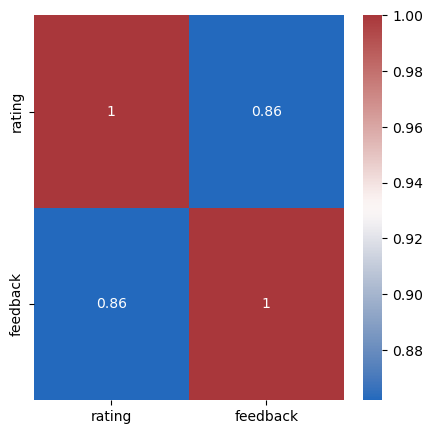

In [47]:
correlations = df_alexa.corr()
f, ax = plt.subplots(figsize = (5, 5))
sns.heatmap(correlations, annot = True, cmap = "vlag")

In [48]:
# Because the two variables are correlated with each other. We have to delete the variable rating.

## Step#3: Word Cloud

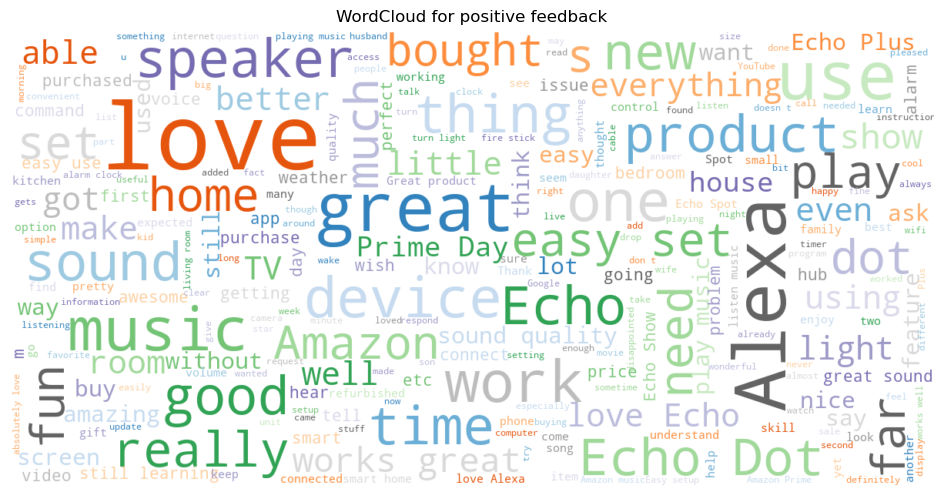

In [49]:
#Let's see the plot of wordcloud of dataset with 5 stars
wordcloud_plot(positive['verified_reviews'], 'WordCloud for positive feedback')

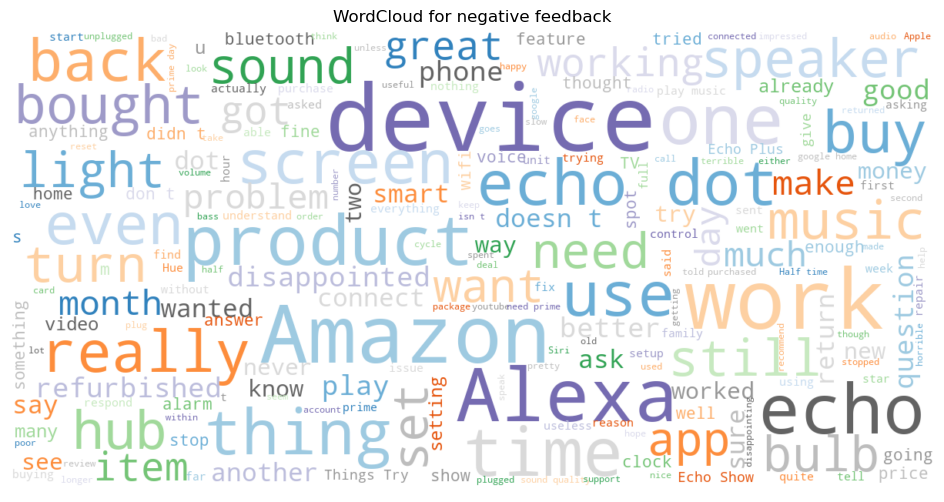

In [50]:
#Let's see the plot of wordcloud of dataset with 1 star
wordcloud_plot(negative['verified_reviews'], 'WordCloud for negative feedback')

## Step#4: Data cleaning/ fearure enginering

In [51]:
df_alexa = df_alexa.drop(['date', 'rating'], axis = 1)

In [52]:
variation_dummies = pd.get_dummies( df_alexa['variation'], drop_first = True)

In [53]:
variation_dummies

,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3146,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3148,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [54]:
df_alexa.drop(['variation'], axis = 1, inplace = True)

In [55]:
df_alexa = pd.concat([df_alexa, variation_dummies], axis = 1) # соединяет 

In [56]:
df_alexa

,verified_reviews,feedback,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,Love my Echo!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Loved it!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"Sometimes while playing a game, you can answer...",1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,I have had a lot of fun with this thing. My 4 ...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Music,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,"Perfect for kids, adults and everyone in betwe...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3146,"Listening to music, searching locations, check...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3147,"I do love these things, i have them running my...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3148,Only complaint I have is that the sound qualit...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Step#5:  Lemmatizer

In [57]:
df_alexa_lem = lemmatize(df_alexa) # create new data set alexa with use lem

In [58]:
cv = create_count_vectorizer_and_transform(df_alexa) # countvectorizer for origin
cv_lem = create_count_vectorizer_and_transform(df_alexa_lem)  # countvectorizer for lem 

In [59]:
cv_tf_org = create_count_vectorizer_and_tfidf(df_alexa)
cv_tf_lem = create_count_vectorizer_and_tfidf(df_alexa_lem)

In [60]:
# splitting origin dataset
X_train_origin, X_test_origin, y_train_origin, y_test_origin = splitting_dataset_using_count_vectorizer(df_alexa, cv)

In [61]:
X_train_origin.shape, X_test_origin.shape

((2362, 5211), (788, 5211))

In [62]:
# splitting lem dataset
X_train_lem, X_test_lem, y_train_lem, y_test_lem = splitting_dataset_using_count_vectorizer(df_alexa_lem, cv_lem)

In [63]:
X_train_lem.shape, X_test_lem.shape 

((2362, 4528), (788, 4528))

In [64]:
# splitting origin dataset with tfidf
X_train_tf, X_test_tf, y_train_tf, y_test_tf = splitting_dataset_using_count_vectorizer_and_tfidf(df_alexa, cv_tf_org)

In [65]:
X_train_tf.shape, X_test_tf.shape 

((2362, 5211), (788, 5211))

In [66]:
# splitting lem dataset with tfidf
X_train_tf_lem, X_test_tf_lem, y_train_tf_lem, y_test_tf_lem = splitting_dataset_using_count_vectorizer_and_tfidf(df_alexa_lem, cv_tf_lem)

In [67]:
X_train_tf_lem.shape, X_test_tf_lem.shape 

((2362, 4528), (788, 4528))

 ## Step #6: Model traning and Evaluating the model

### Random Forest Classifier

In [68]:
RF_classifier = RandomForestClassifier()

In [1]:
from sklearn.model_selection import GridSearchCV
paramaters = {'n_estimators': [10, 50, 100],
             'criterion': ['gini', 'entropy','log_loss'],
              'max_leaf_nodes': [20, 300, 980]
             }
                   
grid_search = GridSearchCV(estimator =RF_classifier, 
                           param_grid = paramaters, 
                           scoring ='accuracy',
                           cv = 3, 
                           n_jobs = -1)

NameError: name 'RF_classifier' is not defined

In [70]:
grid_search.fit(X_train_origin, y_train_origin)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_leaf_nodes': [20, 300, 980],
                         'n_estimators': [10, 50, 100]},
             scoring='accuracy')

In [71]:
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [72]:
print(" Best Accuracy: {:.2f} %".format(best_accuracy * 100))
print(" Best Parameters: ", best_parameters)

 Best Accuracy: 93.23 %
 Best Parameters:  {'criterion': 'entropy', 'max_leaf_nodes': 980, 'n_estimators': 10}


Train: 
accuracy 0.9902624894157493
              precision    recall  f1-score   support

           0       1.00      0.88      0.93       186
           1       0.99      1.00      0.99      2176

    accuracy                           0.99      2362
   macro avg       0.99      0.94      0.96      2362
weighted avg       0.99      0.99      0.99      2362

----------------------------------------------
Test: 
accuracy 0.9263959390862944
              precision    recall  f1-score   support

           0       0.78      0.25      0.38        71
           1       0.93      0.99      0.96       717

    accuracy                           0.93       788
   macro avg       0.86      0.62      0.67       788
weighted avg       0.92      0.93      0.91       788



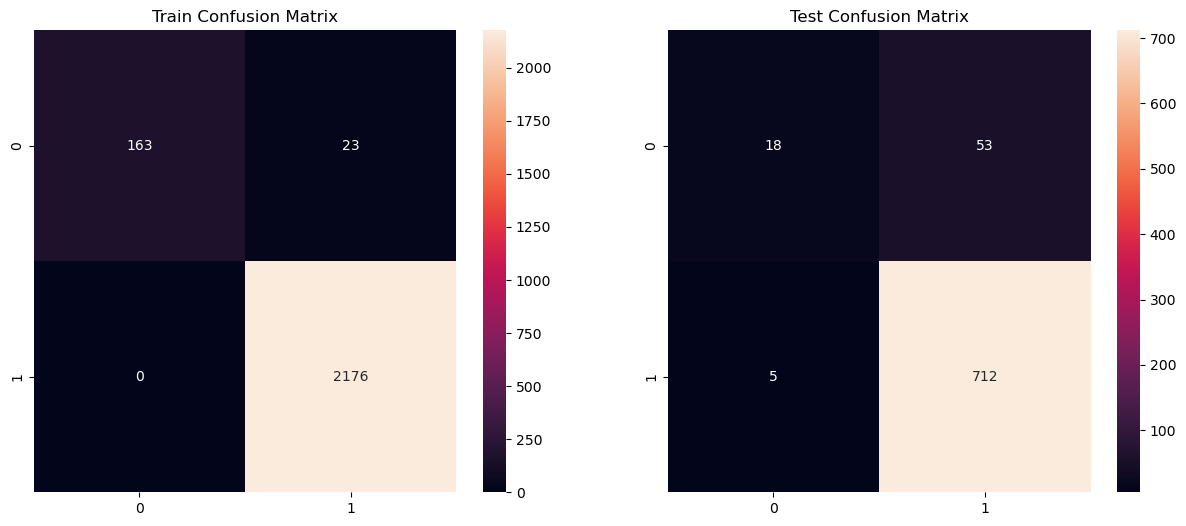

In [73]:
RF_classifier = RandomForestClassifier(n_estimators=10, criterion='entropy', max_leaf_nodes= 980)
RF_classifier.fit(X_train_origin, y_train_origin)
score_show('Random Forest cv', RF_classifier, X_train_origin, X_test_origin, y_train_origin, y_test_origin)

Train: 
accuracy 0.9906858594411516
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       186
           1       0.99      1.00      0.99      2176

    accuracy                           0.99      2362
   macro avg       0.99      0.94      0.97      2362
weighted avg       0.99      0.99      0.99      2362

----------------------------------------------
Test: 
accuracy 0.9238578680203046
              precision    recall  f1-score   support

           0       0.74      0.24      0.36        71
           1       0.93      0.99      0.96       717

    accuracy                           0.92       788
   macro avg       0.83      0.62      0.66       788
weighted avg       0.91      0.92      0.91       788



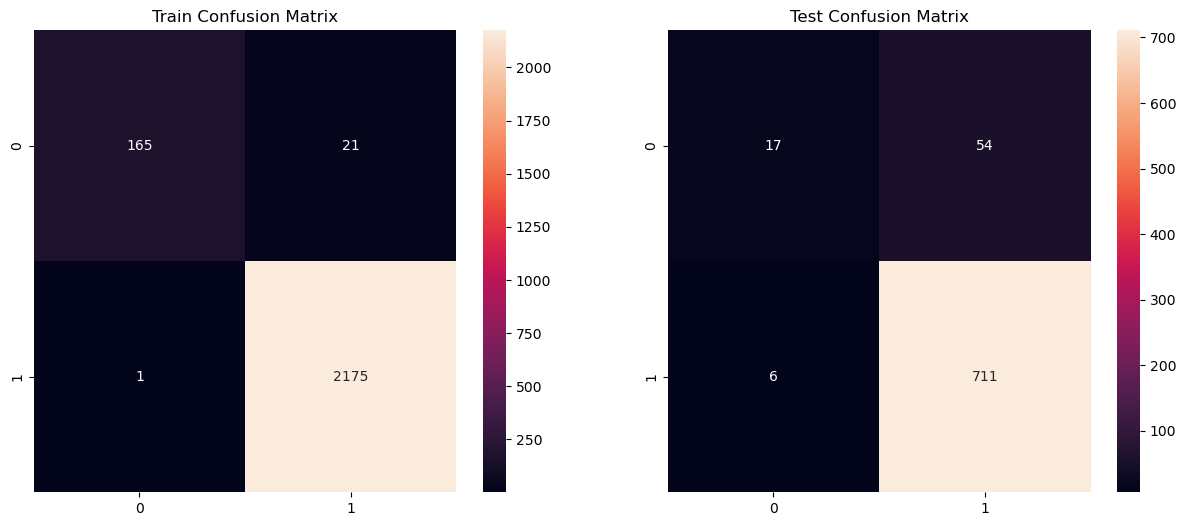

In [74]:
score_show('Random Forest cv lem', RF_classifier, X_train_lem, X_test_lem, y_train_lem, y_test_lem)

Train: 
accuracy 0.9889923793395428
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       186
           1       0.99      1.00      0.99      2176

    accuracy                           0.99      2362
   macro avg       0.99      0.93      0.96      2362
weighted avg       0.99      0.99      0.99      2362

----------------------------------------------
Test: 
accuracy 0.9263959390862944
              precision    recall  f1-score   support

           0       0.88      0.21      0.34        71
           1       0.93      1.00      0.96       717

    accuracy                           0.93       788
   macro avg       0.90      0.60      0.65       788
weighted avg       0.92      0.93      0.91       788



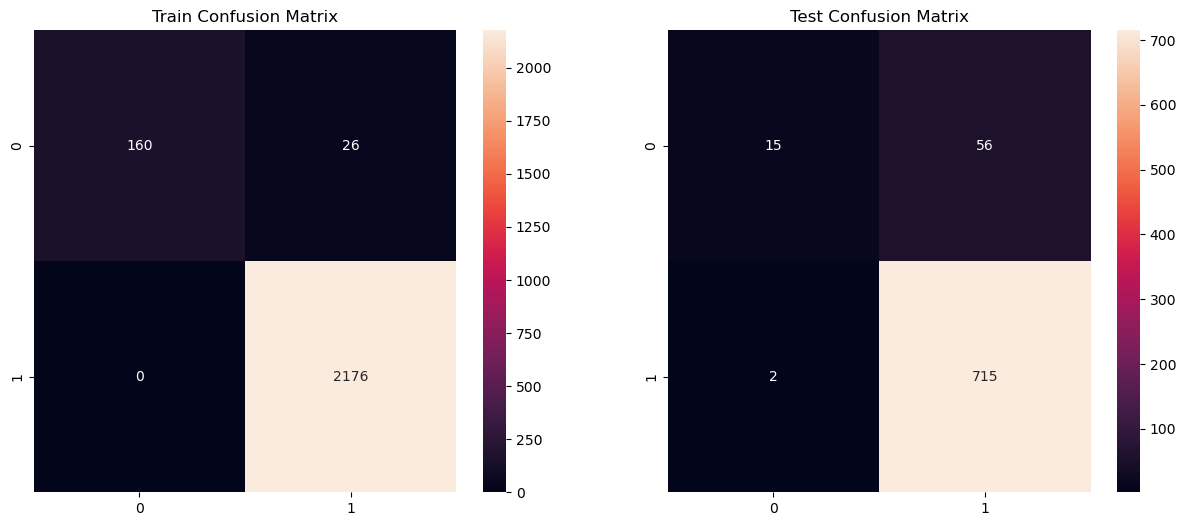

In [75]:
score_show('Random Forest cv tfidf', RF_classifier, X_train_tf, X_test_tf, y_train_tf, y_test_tf)

Train: 
accuracy 0.9885690093141406
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       186
           1       0.99      1.00      0.99      2176

    accuracy                           0.99      2362
   macro avg       0.99      0.93      0.96      2362
weighted avg       0.99      0.99      0.99      2362

----------------------------------------------
Test: 
accuracy 0.9238578680203046
              precision    recall  f1-score   support

           0       0.87      0.18      0.30        71
           1       0.92      1.00      0.96       717

    accuracy                           0.92       788
   macro avg       0.90      0.59      0.63       788
weighted avg       0.92      0.92      0.90       788



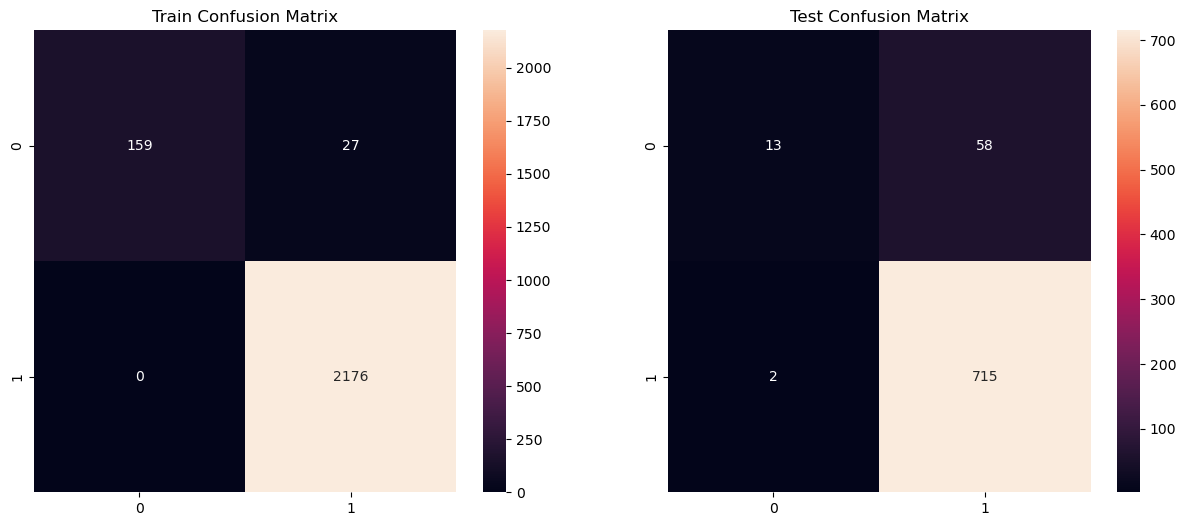

In [76]:
score_show('Random Forest cv tfidf lem', RF_classifier, X_train_tf_lem, X_test_tf_lem, y_train_tf_lem, y_test_tf_lem)

## Decision Tree Classifier

In [77]:
DTC_classifier = DecisionTreeClassifier()

In [78]:
from sklearn.model_selection import GridSearchCV
paramaters = {'criterion': ['gini', 'entropy'],
             'max_depth': [None, 2, 4, 6, 8, 10]
             }
                   
grid_search = GridSearchCV(estimator =DTC_classifier, 
                           param_grid = paramaters, 
                           scoring ='accuracy',
                           cv = 3, 
                           n_jobs = -1)

In [79]:
grid_search.fit(X_train_origin, y_train_origin)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 4, 6, 8, 10]},
             scoring='accuracy')

In [80]:
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [81]:
print(" Best Accuracy: {:.2f} %".format(best_accuracy * 100))
print(" Best Parameters: ", best_parameters) 

 Best Accuracy: 92.08 %
 Best Parameters:  {'criterion': 'entropy', 'max_depth': 2}


Train: 
accuracy 0.9928027095681625
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       186
           1       0.99      1.00      1.00      2176

    accuracy                           0.99      2362
   macro avg       1.00      0.95      0.97      2362
weighted avg       0.99      0.99      0.99      2362

----------------------------------------------
Test: 
accuracy 0.9225888324873096
              precision    recall  f1-score   support

           0       0.60      0.42      0.50        71
           1       0.94      0.97      0.96       717

    accuracy                           0.92       788
   macro avg       0.77      0.70      0.73       788
weighted avg       0.91      0.92      0.92       788



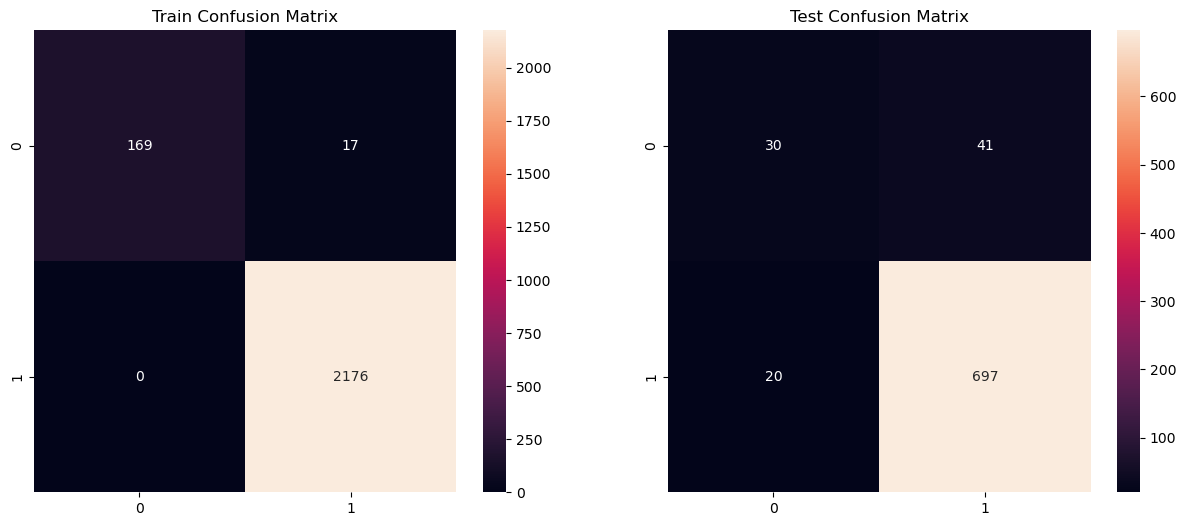

In [82]:
DTC_classifier = DecisionTreeClassifier(criterion= 'entropy', max_depth =None, random_state=0)
DTC_classifier.fit(X_train_origin, y_train_origin)
score_show('Decision Tree Classifier cv', DTC_classifier, X_train_origin, X_test_origin, y_train_origin, y_test_origin)

Train: 
accuracy 0.9928027095681625
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       186
           1       0.99      1.00      1.00      2176

    accuracy                           0.99      2362
   macro avg       1.00      0.95      0.97      2362
weighted avg       0.99      0.99      0.99      2362

----------------------------------------------
Test: 
accuracy 0.9251269035532995
              precision    recall  f1-score   support

           0       0.61      0.46      0.53        71
           1       0.95      0.97      0.96       717

    accuracy                           0.93       788
   macro avg       0.78      0.72      0.74       788
weighted avg       0.92      0.93      0.92       788



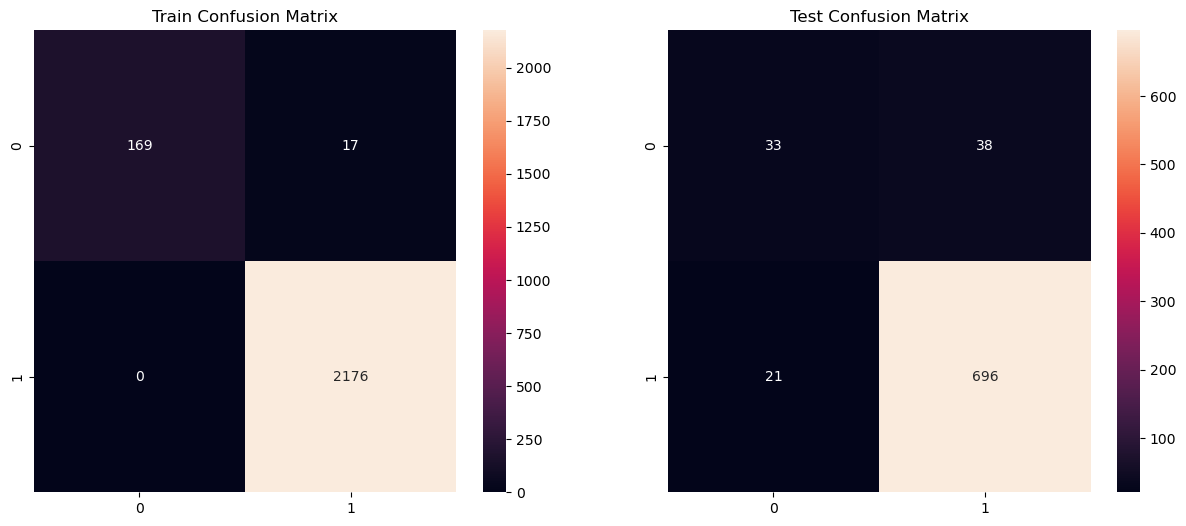

In [83]:
score_show('Decision Tree Classifier cv lem', DTC_classifier, X_train_lem, X_test_lem, y_train_lem, y_test_lem)

Train: 
accuracy 0.9928027095681625
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       186
           1       0.99      1.00      1.00      2176

    accuracy                           0.99      2362
   macro avg       1.00      0.95      0.97      2362
weighted avg       0.99      0.99      0.99      2362

----------------------------------------------
Test: 
accuracy 0.9187817258883249
              precision    recall  f1-score   support

           0       0.58      0.37      0.45        71
           1       0.94      0.97      0.96       717

    accuracy                           0.92       788
   macro avg       0.76      0.67      0.70       788
weighted avg       0.91      0.92      0.91       788



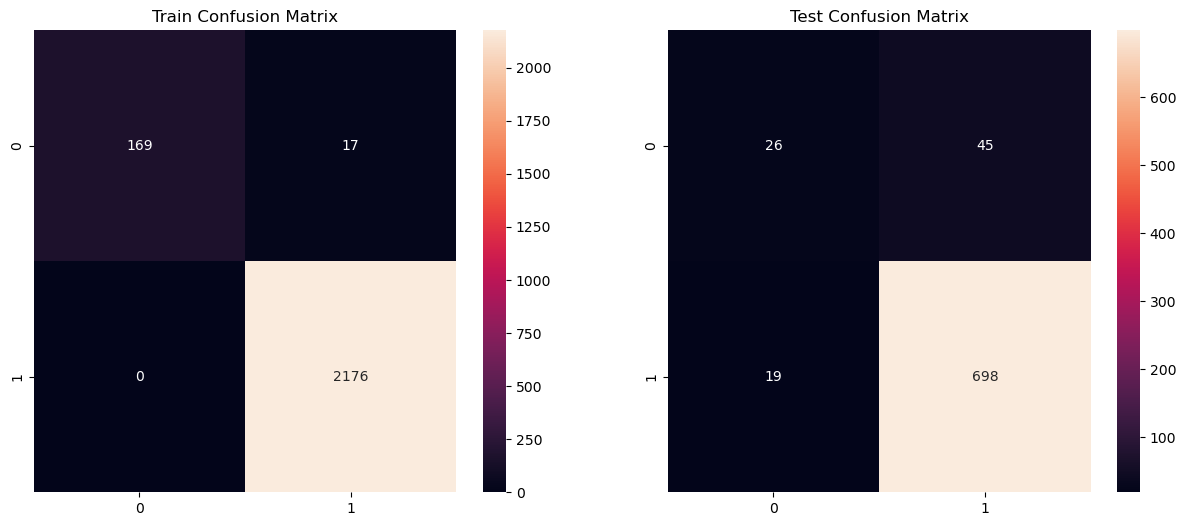

In [84]:
score_show('Decision Tree Classifier cv tfidf', DTC_classifier, X_train_tf, X_test_tf, y_train_tf, y_test_tf)

Train: 
accuracy 0.9928027095681625
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       186
           1       0.99      1.00      1.00      2176

    accuracy                           0.99      2362
   macro avg       1.00      0.95      0.97      2362
weighted avg       0.99      0.99      0.99      2362

----------------------------------------------
Test: 
accuracy 0.9213197969543148
              precision    recall  f1-score   support

           0       0.60      0.38      0.47        71
           1       0.94      0.97      0.96       717

    accuracy                           0.92       788
   macro avg       0.77      0.68      0.71       788
weighted avg       0.91      0.92      0.91       788



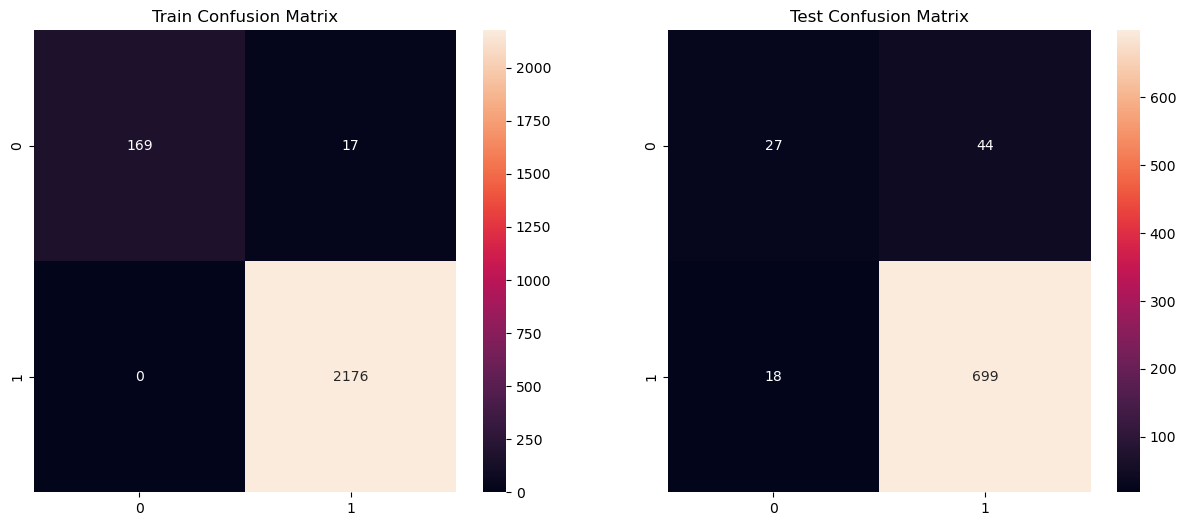

In [85]:
score_show('Decision Tree Classifier cv tfidf lem', DTC_classifier, X_train_tf_lem, X_test_tf_lem, y_train_tf_lem, y_test_tf_lem)

## Support Vector Classifier 

In [86]:
SVC_classifier = SVC()

In [87]:
from sklearn.model_selection import GridSearchCV
paramaters = {'kernel': ['linear','rbf', 'poly'],
              'gamma' : ['scale', 'auto']
             }
                   
grid_search = GridSearchCV(estimator =SVC_classifier, 
                           param_grid = paramaters, 
                           scoring ='accuracy',
                           cv = 3, 
                           n_jobs = -1)

In [88]:
grid_search.fit(X_train_origin, y_train_origin)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy')

In [89]:
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [90]:
print(" Best Accuracy: {:.2f} %".format(best_accuracy * 100))
print(" Best Parameters: ", best_parameters)

 Best Accuracy: 93.56 %
 Best Parameters:  {'gamma': 'scale', 'kernel': 'linear'}


Train: 
accuracy 0.9911092294665538
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       186
           1       0.99      1.00      1.00      2176

    accuracy                           0.99      2362
   macro avg       1.00      0.94      0.97      2362
weighted avg       0.99      0.99      0.99      2362

----------------------------------------------
Test: 
accuracy 0.9289340101522843
              precision    recall  f1-score   support

           0       0.65      0.45      0.53        71
           1       0.95      0.98      0.96       717

    accuracy                           0.93       788
   macro avg       0.80      0.71      0.75       788
weighted avg       0.92      0.93      0.92       788



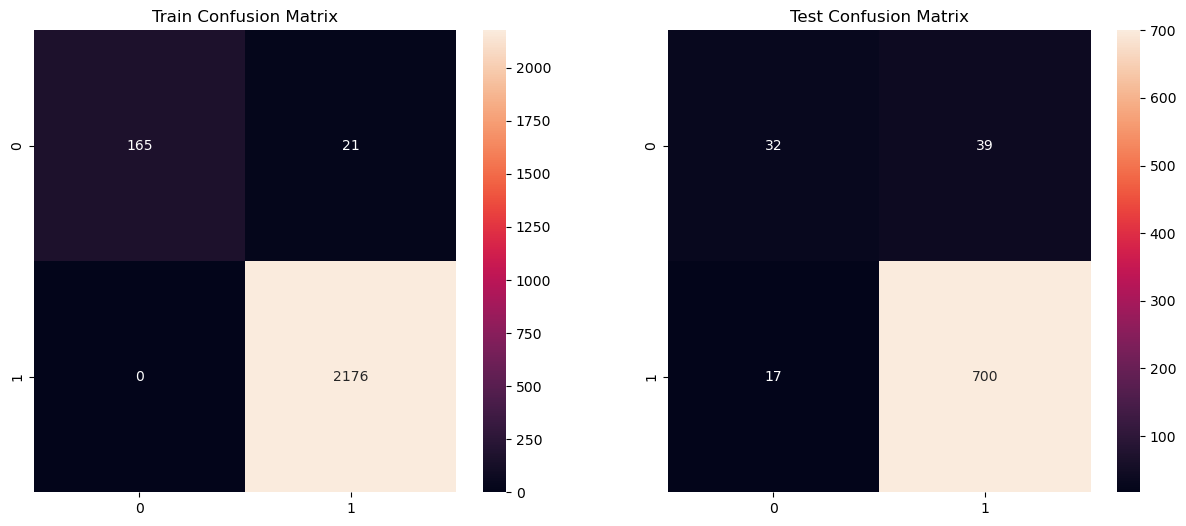

In [91]:
SVC_classifier = SVC(kernel='linear',gamma='scale', random_state = 0)
SVC_classifier.fit(X_train_origin, y_train_origin)
score_show('Support Vector Classifier cv', SVC_classifier, X_train_origin, X_test_origin, y_train_origin, y_test_origin)

Train: 
accuracy 0.9902624894157493
              precision    recall  f1-score   support

           0       1.00      0.88      0.93       186
           1       0.99      1.00      0.99      2176

    accuracy                           0.99      2362
   macro avg       0.99      0.94      0.96      2362
weighted avg       0.99      0.99      0.99      2362

----------------------------------------------
Test: 
accuracy 0.9302030456852792
              precision    recall  f1-score   support

           0       0.68      0.42      0.52        71
           1       0.94      0.98      0.96       717

    accuracy                           0.93       788
   macro avg       0.81      0.70      0.74       788
weighted avg       0.92      0.93      0.92       788



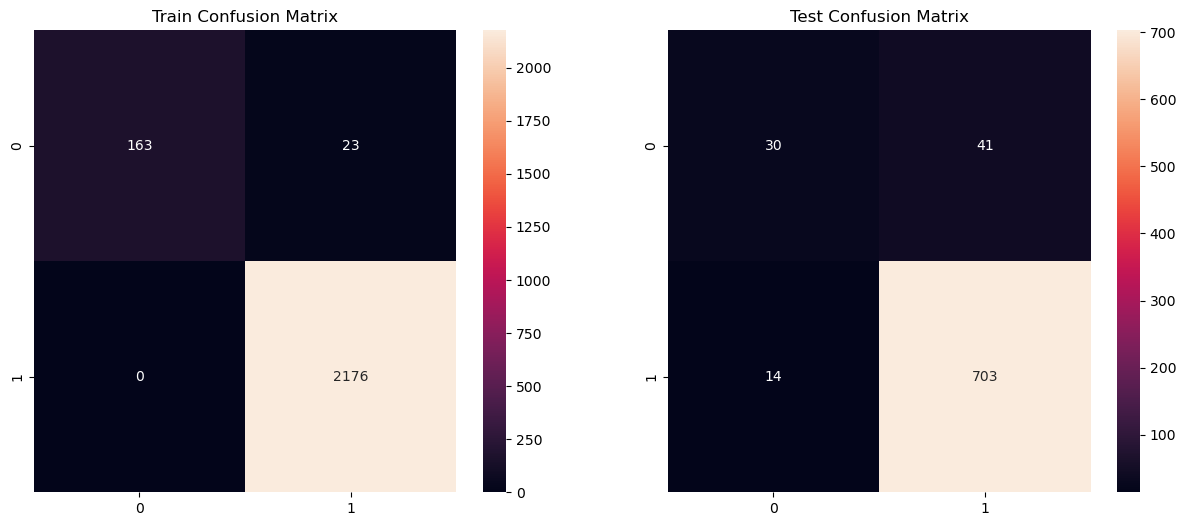

In [92]:
score_show('Support Vector Classifier cv lem', SVC_classifier, X_train_lem, X_test_lem, y_train_lem, y_test_lem)

Train: 
accuracy 0.9712108382726503
              precision    recall  f1-score   support

           0       1.00      0.63      0.78       186
           1       0.97      1.00      0.98      2176

    accuracy                           0.97      2362
   macro avg       0.98      0.82      0.88      2362
weighted avg       0.97      0.97      0.97      2362

----------------------------------------------
Test: 
accuracy 0.9251269035532995
              precision    recall  f1-score   support

           0       0.88      0.20      0.32        71
           1       0.93      1.00      0.96       717

    accuracy                           0.93       788
   macro avg       0.90      0.60      0.64       788
weighted avg       0.92      0.93      0.90       788



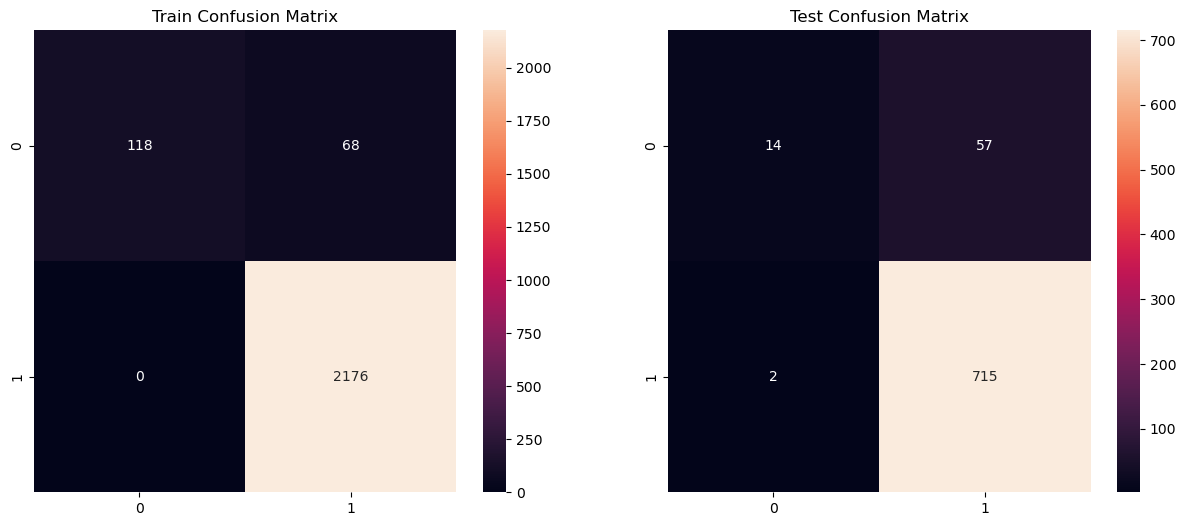

In [93]:
score_show('Support Vector Classifier cv tfidf', SVC_classifier, X_train_tf, X_test_tf, y_train_tf, y_test_tf)

Train: 
accuracy 0.9635901778154107
              precision    recall  f1-score   support

           0       0.99      0.54      0.70       186
           1       0.96      1.00      0.98      2176

    accuracy                           0.96      2362
   macro avg       0.98      0.77      0.84      2362
weighted avg       0.96      0.96      0.96      2362

----------------------------------------------
Test: 
accuracy 0.9213197969543148
              precision    recall  f1-score   support

           0       0.91      0.14      0.24        71
           1       0.92      1.00      0.96       717

    accuracy                           0.92       788
   macro avg       0.92      0.57      0.60       788
weighted avg       0.92      0.92      0.89       788



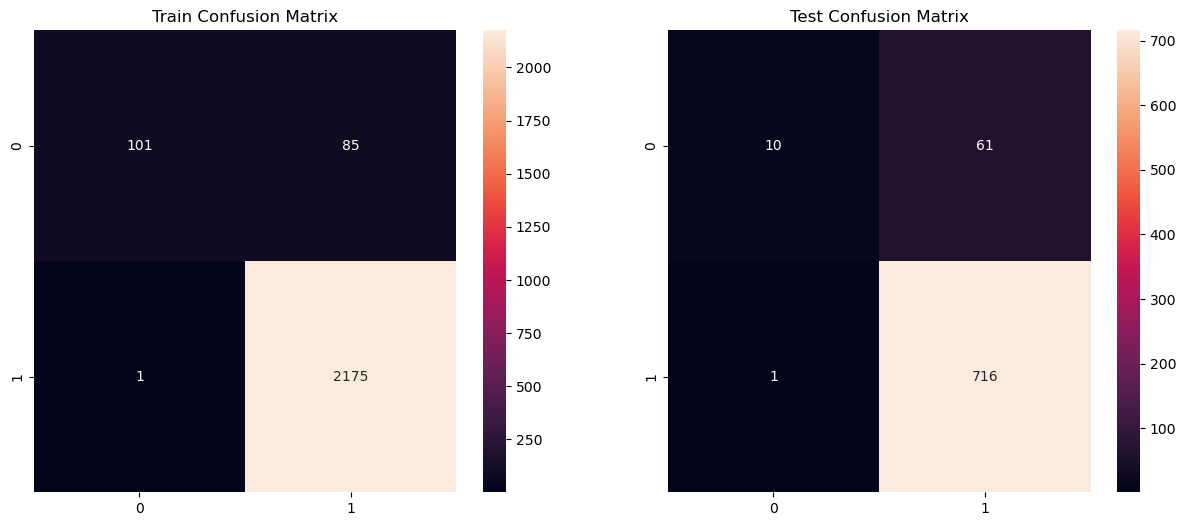

In [94]:
score_show('Support Vector Classifier cv tfidf lem', SVC_classifier, X_train_tf_lem, X_test_tf_lem, y_train_tf_lem, y_test_tf_lem)

## KNN

In [95]:
KNN_classifier = KNeighborsClassifier()

In [96]:
from sklearn.model_selection import GridSearchCV
paramaters = {'n_neighbors': [3, 5, 11, 19],
             'weights': ['uniform', 'distance'],
             'metric': ['minkowski', 'euclidean', 'manhattan']
             }
                   
grid_search = GridSearchCV(estimator =KNN_classifier, 
                           param_grid = paramaters, 
                           scoring ='accuracy',
                           cv = 3, 
                           n_jobs = -1)

In [97]:
grid_search.fit(X_train_origin, y_train_origin)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 11, 19],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [98]:
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [99]:
print(" Best Accuracy: {:.2f} %".format(best_accuracy * 100))
print(" Best Parameters: ", best_parameters) 

 Best Accuracy: 92.89 %
 Best Parameters:  {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


Train: 
accuracy 0.9928027095681625
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       186
           1       0.99      1.00      1.00      2176

    accuracy                           0.99      2362
   macro avg       1.00      0.95      0.97      2362
weighted avg       0.99      0.99      0.99      2362

----------------------------------------------
Test: 
accuracy 0.9251269035532995
              precision    recall  f1-score   support

           0       0.93      0.18      0.31        71
           1       0.93      1.00      0.96       717

    accuracy                           0.93       788
   macro avg       0.93      0.59      0.63       788
weighted avg       0.93      0.93      0.90       788



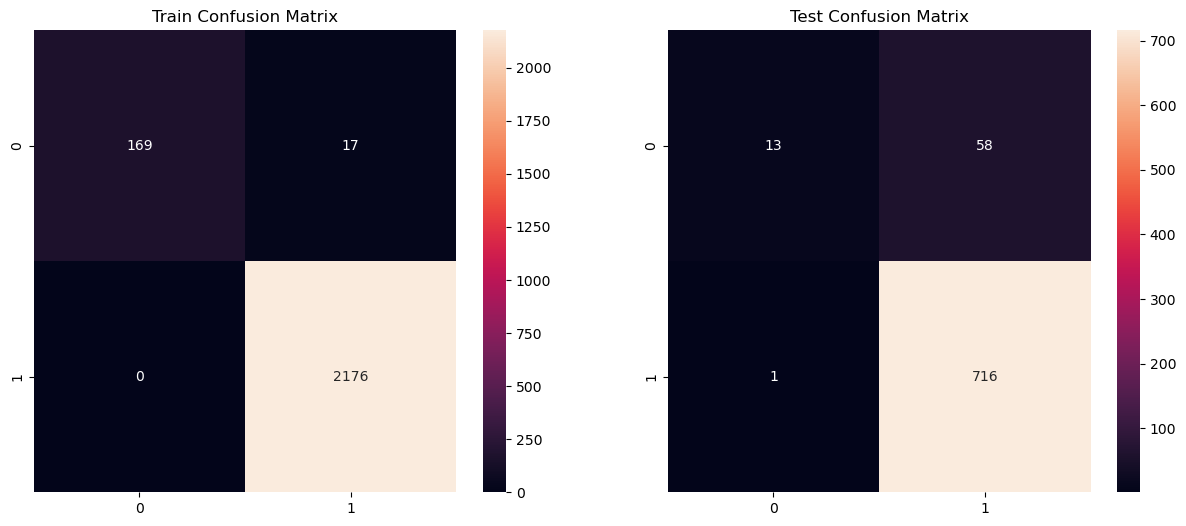

In [100]:
KNN_classifier = KNeighborsClassifier(n_neighbors=19, metric = 'manhattan', weights= 'distance', p=2)
KNN_classifier.fit(X_train_origin, y_train_origin)
score_show('KNeighbors Classifier cv', KNN_classifier, X_train_origin, X_test_origin, y_train_origin, y_test_origin)

Train: 
accuracy 0.9928027095681625
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       186
           1       0.99      1.00      1.00      2176

    accuracy                           0.99      2362
   macro avg       1.00      0.95      0.97      2362
weighted avg       0.99      0.99      0.99      2362

----------------------------------------------
Test: 
accuracy 0.9263959390862944
              precision    recall  f1-score   support

           0       1.00      0.18      0.31        71
           1       0.93      1.00      0.96       717

    accuracy                           0.93       788
   macro avg       0.96      0.59      0.64       788
weighted avg       0.93      0.93      0.90       788



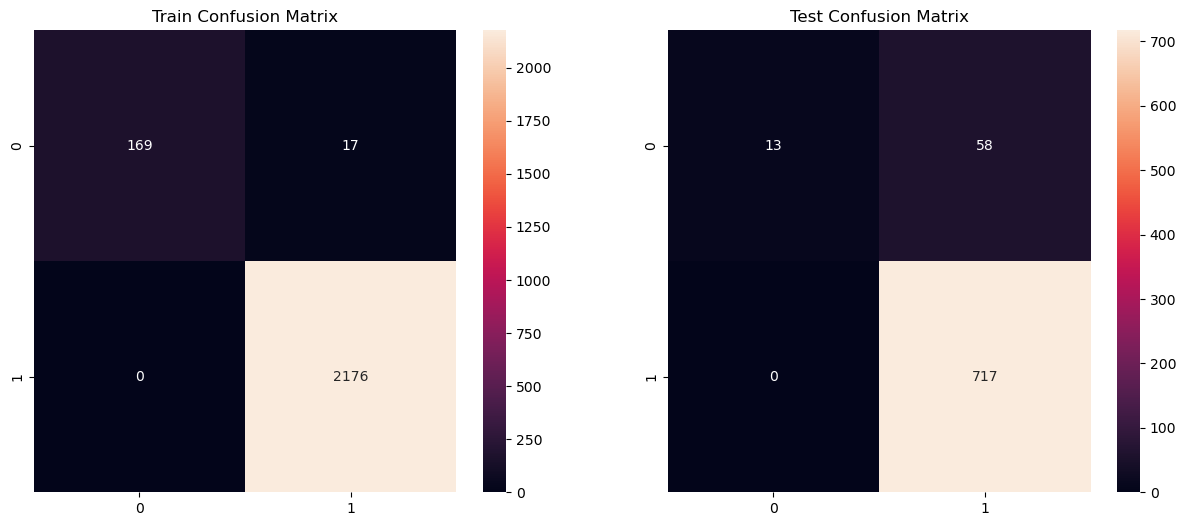

In [101]:
score_show('KNeighbors Classifier cv lem', KNN_classifier, X_train_lem, X_test_lem, y_train_lem, y_test_lem)

Train: 
accuracy 0.9928027095681625
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       186
           1       0.99      1.00      1.00      2176

    accuracy                           0.99      2362
   macro avg       1.00      0.95      0.97      2362
weighted avg       0.99      0.99      0.99      2362

----------------------------------------------
Test: 
accuracy 0.9238578680203046
              precision    recall  f1-score   support

           0       0.87      0.18      0.30        71
           1       0.92      1.00      0.96       717

    accuracy                           0.92       788
   macro avg       0.90      0.59      0.63       788
weighted avg       0.92      0.92      0.90       788



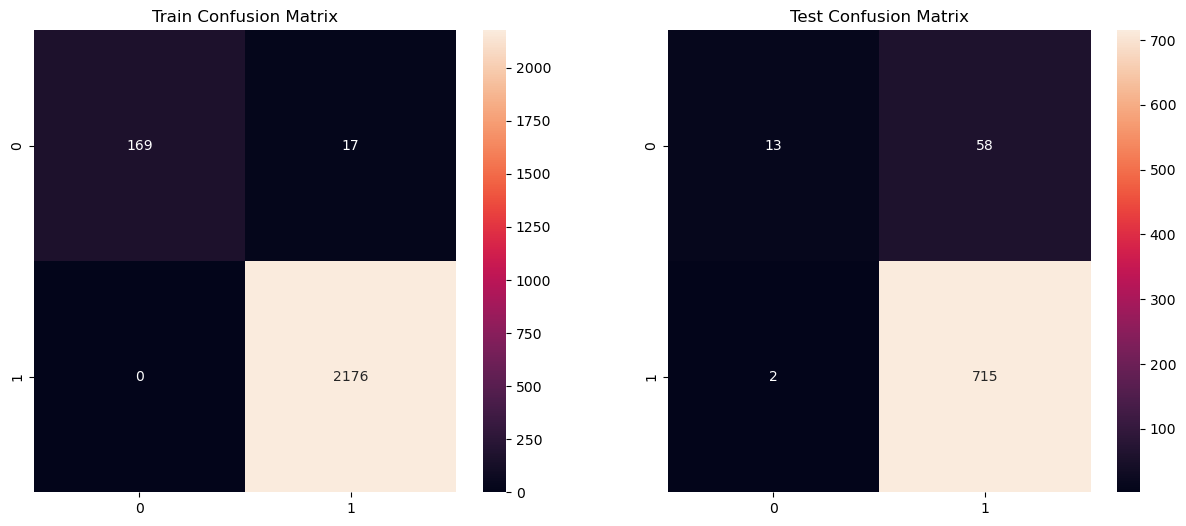

In [102]:
score_show('KNeighbors Classifier cv tfidf', KNN_classifier, X_train_tf, X_test_tf, y_train_tf, y_test_tf)

Train: 
accuracy 0.9928027095681625
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       186
           1       0.99      1.00      1.00      2176

    accuracy                           0.99      2362
   macro avg       1.00      0.95      0.97      2362
weighted avg       0.99      0.99      0.99      2362

----------------------------------------------
Test: 
accuracy 0.9263959390862944
              precision    recall  f1-score   support

           0       0.93      0.20      0.33        71
           1       0.93      1.00      0.96       717

    accuracy                           0.93       788
   macro avg       0.93      0.60      0.64       788
weighted avg       0.93      0.93      0.90       788



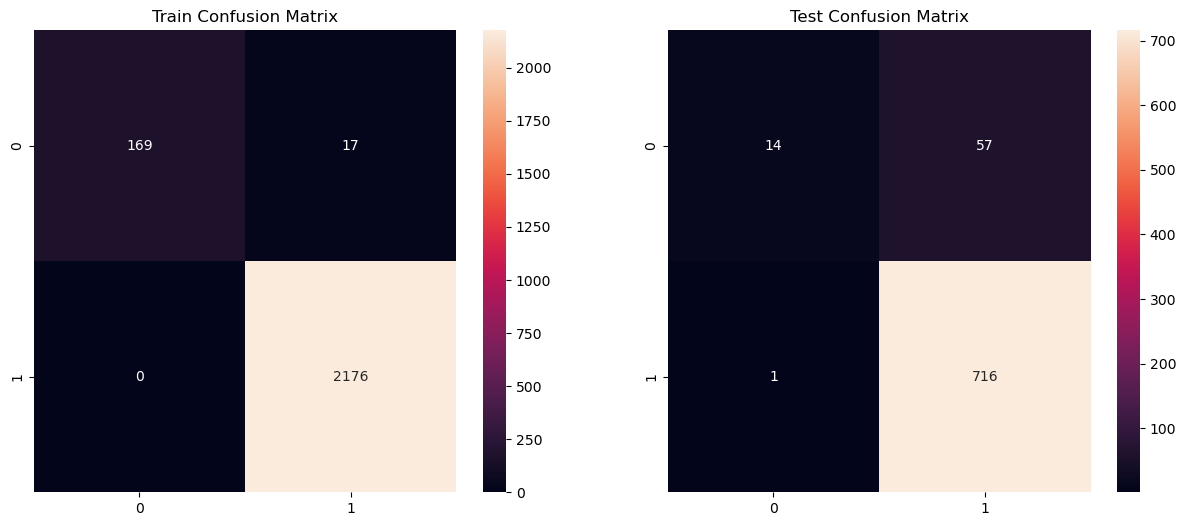

In [103]:
score_show('KNeighbors Classifier cv tfidf lem', KNN_classifier, X_train_tf_lem, X_test_tf_lem, y_train_tf_lem, y_test_tf_lem)

In [108]:
show_results()

Accuracy
                                 modelName  accuracy_test  accuracy_train
9         Support Vector Classifier cv lem       0.930203        0.990262
8             Support Vector Classifier cv       0.928934        0.991109
0                         Random Forest cv       0.926396        0.990262
2                   Random Forest cv tfidf       0.926396        0.988992
13            KNeighbors Classifier cv lem       0.926396        0.992803
15      KNeighbors Classifier cv tfidf lem       0.926396        0.992803
5          Decision Tree Classifier cv lem       0.925127        0.992803
10      Support Vector Classifier cv tfidf       0.925127        0.971211
12                KNeighbors Classifier cv       0.925127        0.992803
1                     Random Forest cv lem       0.923858        0.990686
3               Random Forest cv tfidf lem       0.923858        0.988569
14          KNeighbors Classifier cv tfidf       0.923858        0.992803
4              Decision Tree 

### Conclusion:
### The best models is:
###  Support Vector Classifier Convectorizer Lematization has accuracy from train set 99% and the accuracy from test set 93%.
###  Decision Tree Classifier Convectorizer Lematization has precision from train set 99% and from test set 94%.